<a href="https://colab.research.google.com/github/cyFou/testColab/blob/main/testSlamCv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#source de ce test :
# https://learnopencv.com/monocular-slam-in-python/
# https://zxh.me/posts/2022-12-19-monocular-visual-odometry/

In [8]:
import os
import random
from pathlib import Path
import requests

import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

import torch




In [ ]:
image_url = ["https://www.camif-habitat.fr/wp-content/uploads/data/2021/11/23738/amenagement-espace.jpg",
             "https://www.depreux-construction.com/wp-content/uploads/2019/08/agencement-interieur-construction-maison.jpg"]


def rescale_by_width(image, target_width, method=cv2.INTER_LANCZOS4):
    """Rescale `image` to `target_width` (preserving aspect ratio)."""
    h = int(round(target_width * image.shape[0] / image.shape[1]))
    return cv2.resize(image, (target_width, h), interpolation=method)

liste_image = []
for img in image_url:
  response = requests.get(img)
  image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
  selected_image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
  selected_image = cv2.cvtColor(selected_image, cv2.COLOR_BGR2RGB)
  liste_image.append(rescale_by_width(selected_image,300))

#afficher de cahque image unitaire
# for i, img in enumerate(liste_image):
#     plt.figure()
#     plt.imshow(img)
#     plt.title(f'Image {i+1}')
#     plt.axis('off')
#     plt.show()

#affichage d'une image + une seconde (depth, point...)
# num_samples = 1
# for i in liste_image:
#     fig, axs = plt.subplots(2, 1)
#     axs[0].imshow(i)
#     axs[0].set_title('img')
#     axs[1].imshow(i)
#     plt.show()

#affichage d'une image brut
# plt.imshow(liste_image[0])

In [11]:
def to_rad(th):
    return th*np.pi / 180

def pinhole_intrinsic(fov, width, height):
    """This intrinsic matrix works based on open3d visualization"""
    focal_length = 0.5 * width * math.tan(to_rad(fov/2))
    fx, fy, cx, cy = (focal_length,
                      focal_length,
                      width/2,
                      height/2)
    return width, height, fx, fy, cx, cy



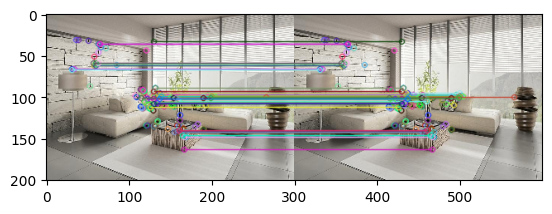

In [25]:
###################################
## Extraction des points + matching

orbimg = liste_image[0]
width, height, fx, fy, cx, cy = pinhole_intrinsic(90.0,orbimg.shape[1],orbimg.shape[0])

orbimg = liste_image[0]
orb = cv2.ORB_create(nfeatures=1000)
# Detect keypoints and compute descriptors for the first image
keypoints1, descriptors1 = orb.detectAndCompute(orbimg, None)

# Detect keypoints and compute descriptors for the second image
keypoints2, descriptors2 = orb.detectAndCompute(orbimg, None)

# Initialize the BFMatcher with default params
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors between frame I and frame I+1
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance (best matches first)
matches = sorted(matches, key=lambda x: x.distance)


oimg = cv2.drawMatches(orbimg,keypoints1,orbimg,keypoints2,matches[:50],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(oimg)

In [5]:

###################################
## A voir pour du flowpoint


# Parameters for lucas kanade optical flow
lk_params = dict(winSize=(15, 15),

maxLevel=2,
criteria=(cv2.TERM_CRITERIA_EPS |   cv2.TERM_CRITERIA_COUNT, 10, 0.03))

kp1 = cv2.KeyPoint_convert(sorted(keypoints1, key=lambda p: p.response, reverse=True))

# Calculate optical flow
kp2, status, err = cv2.calcOpticalFlowPyrLK(orbimg, orbimg, kp1, None, **lk_params)

# Select good points
good_new = kp2[status.ravel() == 1]
good_old = kp1[status.ravel() == 1]

In [27]:

# Extract matched keypoints
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

# Camera intrinsic parameters (example values, replace with your camera's calibration data)
K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]])

# Compute the Fundamental matrix using RANSAC
F, inliers = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
print(F)

# Compute the Essential matrix using the camera's intrinsic parameters
E = K.T @ F @ K

# Decompose the Essential matrix to get R and t
_, R, t, mask = cv2.recoverPose(E, pts1, pts2, K)
print(t)

[[-2.16749057e-19  4.84145008e-04 -1.75501923e-01]
 [-4.84145008e-04  2.12116236e-19 -6.33130219e-02]
 [ 1.75501923e-01  6.33130219e-02  7.10542736e-15]]
[[-0.68102086]
 [ 0.63548367]
 [ 0.36382837]]
